This tests if `forward` still works after making ControlNetXSModel savable via `register_to_config` & `save_pretrained`

In [1]:
import torch

In [2]:
device = 'mps'
device_dtype = torch.float32

## Load the model

In [3]:
from diffusers.models import AutoencoderKL
from diffusers import StableDiffusionXLPipeline

In [4]:
model = "stabilityai/stable-diffusion-xl-base-1.0"
vae = AutoencoderKL.from_pretrained("stabilityai/sdxl-vae", torch_dtype=device_dtype)

In [5]:
sdxl_pipe = StableDiffusionXLPipeline.from_pretrained(model, vae=vae, torch_dtype=device_dtype).to(device)
sdxl_unet = sdxl_pipe.unet

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
from diffusers.models.controlnetxs import ControlNetXSModel

In [7]:
cnxs = ControlNetXSModel.from_pretrained('weights/cnxs').to(device)

In [8]:
cnxs.base_model = sdxl_unet

___

## Prepare the input to it

(Later, this will be done by the corresponding pipeline)

In [9]:
prompt = 'A turtle'

In [10]:
from diffusers.utils import load_image

In [11]:
try: original_image = load_image('https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png')
except Exception: original_image = load_image('/Users/umer/Desktop/input_image_vermeer.png')
image = original_image

I will need to use some preprocessing functions from `StableDiffusionControlNetPipeline`, so let create an instance

In [12]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

(We need a `StableDiffusionControlNetPipeline` instead of a regular `StableDiffusionPipeline` because it has a `prepare_image` method)

In [13]:
controlnet = ControlNetModel.from_pretrained('lllyasviel/sd-controlnet-canny', torch_dtype=device_dtype)
pipe = StableDiffusionControlNetPipeline.from_pretrained('runwayml/stable-diffusion-v1-5', controlnet=controlnet, torch_dtype=device_dtype).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [14]:
guidance_scale = 7.5
do_classifier_free_guidance = guidance_scale > 1.0

In [15]:
# 2. Define call parameters
batch_size = 1 # because prompt is a single string
num_images_per_prompt  = 1

In [16]:
prompt_embeds, negative_prompt_embeds, _, _ = sdxl_pipe.encode_prompt(prompt)
prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])
prompt_embeds.shape

torch.Size([2, 77, 2048])

In [17]:
# 6. Prepare latent variables
num_channels_latents = cnxs.base_model.config.in_channels # we're using our unet here!
num_channels_latents

4

In [18]:
# Default values for prepare_image
height, width = None, None
generator = None
latents = None
guess_mode = False

In [19]:
# 4. Prepare image
image = pipe.prepare_image(
    image=image,
    width=width,
    height=height,
    batch_size=batch_size * num_images_per_prompt,
    num_images_per_prompt=num_images_per_prompt,
    device=device,
    dtype=controlnet.dtype,
    do_classifier_free_guidance=do_classifier_free_guidance,
    guess_mode=guess_mode,
)
height, width = image.shape[-2:]
height, width, image.shape

(512, 512, torch.Size([2, 3, 512, 512]))

In [20]:
# Default values for set_timesteps
num_inference_steps = 50

In [21]:
# 5. Prepare timesteps
pipe.scheduler.set_timesteps(num_inference_steps, device=device)
timesteps = pipe.scheduler.timesteps

In [22]:
# 6. Prepare latent variables
latents = pipe.prepare_latents(
    batch_size * num_images_per_prompt,
    num_channels_latents,
    height,
    width,
    prompt_embeds.dtype,
    device,
    generator,
    latents,
)

In [23]:
latents.shape

torch.Size([1, 4, 64, 64])

In [24]:
# 8. Denoising loop
num_warmup_steps = len(timesteps) - num_inference_steps * pipe.scheduler.order

i,t = 0, timesteps[0] # NOTE: We only do 1 step for testing

In [25]:
# expand the latents if we are doing classifier free guidance
latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

In [26]:
# controlnet(s) inference
# guess_mode == False
control_model_input = latent_model_input
controlnet_prompt_embeds = prompt_embeds

In [27]:
latent_model_input.shape, t, prompt_embeds.shape

(torch.Size([2, 4, 64, 64]),
 tensor(981, device='mps:0'),
 torch.Size([2, 77, 2048]))

We still need the hint

In [28]:
hint_image = original_image

In [29]:
import cv2
class CannyDetector:
    def __call__(self, img, low_threshold, high_threshold):
        return cv2.Canny(img, low_threshold, high_threshold)

In [30]:
import numpy as np
def get_canny_edges(image, size=512, threshold=(50, 200)):
    image = np.array(image).astype(np.uint8)
    edges = CannyDetector()(image, *threshold)  # original sized greyscale edges
    edges = edges / 255.
    return edges

In [31]:
import matplotlib.pyplot as plt

In [32]:
edges = get_canny_edges(hint_image)

In [33]:
edges.shape

(512, 512)

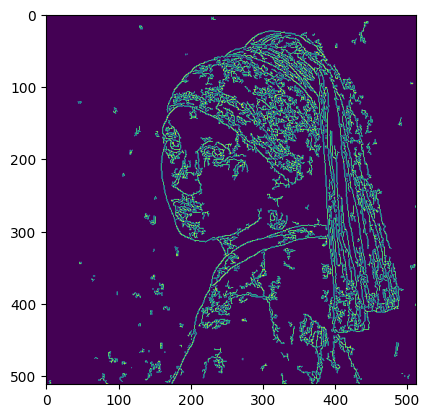

In [34]:
plt.imshow(edges);

In [35]:
num_samples=2

from einops import repeat
edges = repeat(torch.tensor(edges), 'h w -> b c h w', b=num_samples, c=3)

In [36]:
image.shape, edges.shape

(torch.Size([2, 3, 512, 512]), torch.Size([2, 3, 512, 512]))

In [37]:
x = latent_model_input
t = t
c = {}
hint = edges.to(device, dtype=device_dtype)
no_control = False

## Run the model!

In [38]:
cnxs.debug = True
result = cnxs(x, t, prompt_embeds, c, hint)

>>> >>> Start 1
1] h_base.shape: [2, 320, 64, 64]
1] h_ctrl.shape: [2, 32, 64, 64]
>>> After base->ctrl concat
1] h_ctrl.shape: [2, 352, 64, 64]
>>> After block application
1] h_base.shape: [2, 320, 64, 64]
1] h_ctrl.shape: [2, 32, 64, 64]
>>> After ctrl->base add
1] h_base.shape: [2, 320, 64, 64]
 - - - - - - - - - - - - - 
>>> >>> Start 2
2] h_base.shape: [2, 320, 64, 64]
2] h_ctrl.shape: [2, 32, 64, 64]
>>> After base->ctrl concat
2] h_ctrl.shape: [2, 352, 64, 64]
>>> After block application
2] h_base.shape: [2, 320, 64, 64]
2] h_ctrl.shape: [2, 32, 64, 64]
>>> After ctrl->base add
2] h_base.shape: [2, 320, 64, 64]
 - - - - - - - - - - - - - 
>>> >>> Start 3
3] h_base.shape: [2, 320, 64, 64]
3] h_ctrl.shape: [2, 32, 64, 64]
>>> After base->ctrl concat
3] h_ctrl.shape: [2, 352, 64, 64]
>>> After block application
3] h_base.shape: [2, 320, 32, 32]
3] h_ctrl.shape: [2, 32, 32, 32]
>>> After ctrl->base add
3] h_base.shape: [2, 320, 32, 32]
 - - - - - - - - - - - - - 
>>> >>> Start 4
4] 

In [39]:
result.sample.shape

torch.Size([2, 4, 64, 64])

**Running 1 step works!**

In [40]:
cnxs.debug = False

___

## Let's now run the denoising loop with `no_control=True`

Some prep to better inspect the denoising process

In [41]:
lats = []

In [126]:
def save_latents(i,t,lat):
    global lats
    if i==0 and len(lat)>0: lats = []
    lats.append((i,t,lat))

from PIL import Image, ImageOps
from tqdm.notebook import tqdm
from functools import partial

def lat2img(lat, resize_to=None, output_type='pil'):
    with torch.no_grad():
        ims = cnxs_pipe.vae.decode(lat / cnxs_pipe.vae.config.scaling_factor, return_dict=False)[0]
        ims = cnxs_pipe.image_processor.postprocess(ims, output_type=output_type)
        if resize_to is not None:
            if output_type=='pil': ims = [im.resize(resize_to) for im in ims]
            else: print(f'Not resizing as output_type = {output_type} requested')
    return ims

def only_lat(o): return o[-1] if isinstance(o,tuple) else o
def lats2imgs(lats, resize_to=None, output_type='pil',pbar=True):
    if pbar: lats = tqdm(lats)
    ims = [lat2img(only_lat(lat), resize_to, output_type) for lat in lats]
    if output_type=='pt': ims = [im.cpu() for im in ims]
    return ims

real_idx = None
def plot_latents_to_pil_grid(lats, every=5, cols=7, im_size=(300, 300), pbar=True, border=2, return_ims=True, output_type='pil'):
    global real_idx
    
    real_idx = partial(lambda o,every,total: min(total-1,every*o), every=every, total=len(lats))
    
    titles = [f'Image {i}' for i, _, _ in lats if i % every == 0 or i == len(lats)-1]
    lats = [lat for i, _, lat in lats if i % every == 0 or i == len(lats)-1]
    if pbar: latents = tqdm(lats)
    ims = [lat2img(lat, resize_to=im_size, output_type=output_type)[0] for lat in lats]
    ims_bordered = [ImageOps.expand(im, border=2, fill='black') for im in ims]
    im_size = (im_size[0]+border, im_size[1]+border)

    rows = len(ims) // cols
    if rows * cols < len(ims): rows += 1

    grid_image = Image.new('RGB', (cols * im_size[0], rows * im_size[1]), color='grey')

    for i, img in enumerate(ims_bordered):
        x_offset = (i % cols) * im_size[0]
        y_offset = (i // cols) * im_size[1]
        grid_image.paste(img, (x_offset, y_offset))

    if return_ims: return grid_image, ims
    else: return grid_image

Okay, let's go

In [43]:
prompt = 'cinematic, shoe in the streets, made from meat, photorealistic shoe, highly detailed'
neg_prompt = 'lowres, bad anatomy, worst quality, low quality'

In [44]:
image = load_image('input_images/shoe.png')
edges = get_canny_edges(image)

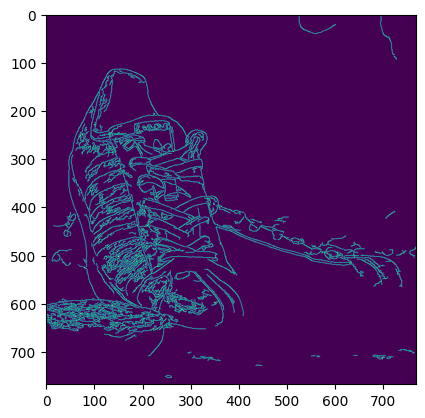

In [45]:
plt.imshow(edges)

In [46]:
cnxs.no_control = True

In [47]:
from diffusers.pipelines.controlnet_xs.pipeline_controlnet_xs_sd_xl import StableDiffusionXLControlNetXSPipeline

In [48]:
cnxs_pipe = StableDiffusionXLControlNetXSPipeline(
    vae=sdxl_pipe.vae,
    text_encoder=sdxl_pipe.text_encoder,
    text_encoder_2=sdxl_pipe.text_encoder_2,
    tokenizer=sdxl_pipe.tokenizer,
    tokenizer_2=sdxl_pipe.tokenizer_2,
    unet=sdxl_pipe.unet,
    controlnet=cnxs,
    scheduler=sdxl_pipe.scheduler,
)

In [49]:
# takes ~3min to run on cpu / ~1.5min on mps
result = cnxs_pipe(prompt, negative_prompt=neg_prompt,image=edges, callback=save_latents)

  0%|          | 0/50 [00:00<?, ?it/s]

In [50]:
type(result), type(result.images[0])

(diffusers.pipelines.stable_diffusion_xl.pipeline_output.StableDiffusionXLPipelineOutput,
 PIL.Image.Image)

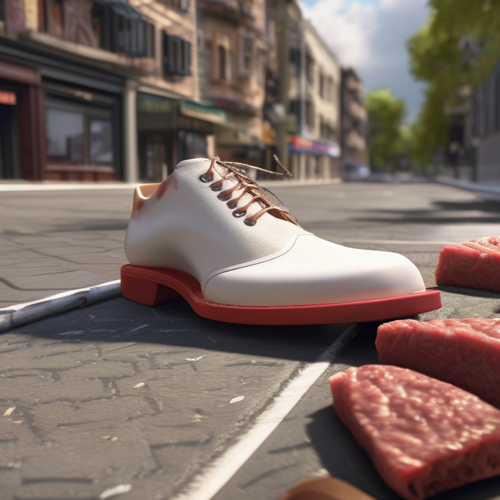

In [51]:
result.images[0].resize((500,500))

**It works!**

  0%|          | 0/11 [00:00<?, ?it/s]

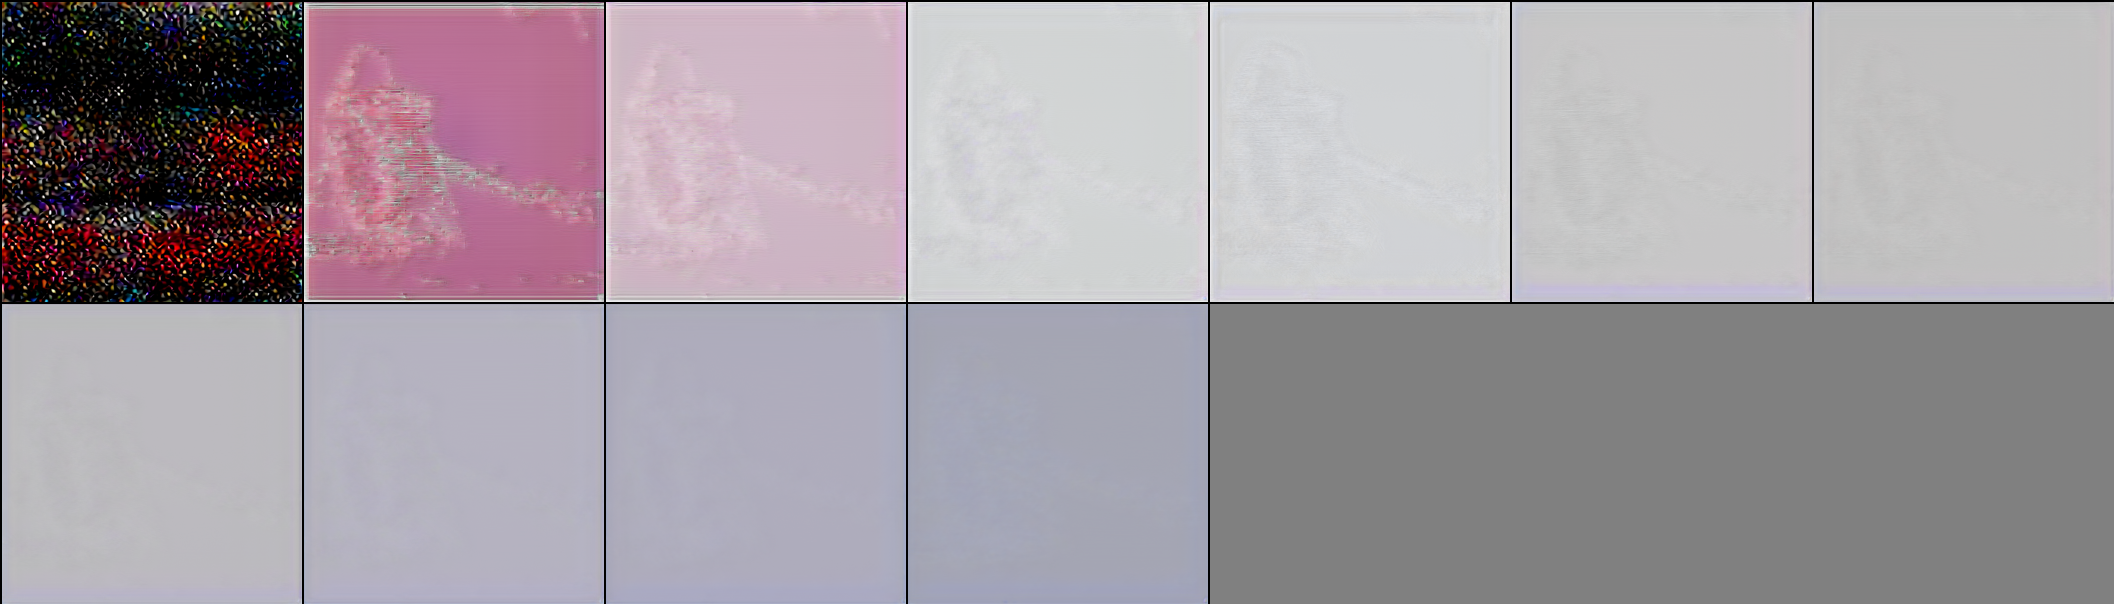

In [63]:
grid, ims_sdxl = plot_latents_to_pil_grid(lats)
grid

## Let's now run the denoising loop

In [53]:
cnxs.no_control = False

In [54]:
# RuntimeError: Given ... expected input [2, 1, 512, 512] to have 3 channels, but got 1 channels instead
# -> hint has 1 channel, but should have 3
# let'cheat
edges_tensor = torch.tensor(edges)
three_edges = torch.stack((edges_tensor,edges_tensor,edges_tensor))
three_edges.shape

torch.Size([3, 768, 768])

In [55]:
# # Produces shape mismatch at h_ctrl += guided_hint of [2, 32, 64, 64] != [4, 32, 64, 64]
# # As cnxs.forward did run, I assume the error is due to negative prompting. Maybe it's double the inputs from 2 -> 4
# # (Altough it shouldn't. We should have 3 inputs: uncond, cond, neg.)
result_controlled = cnxs_pipe(prompt, negative_prompt=neg_prompt,image=three_edges, callback=save_latents)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

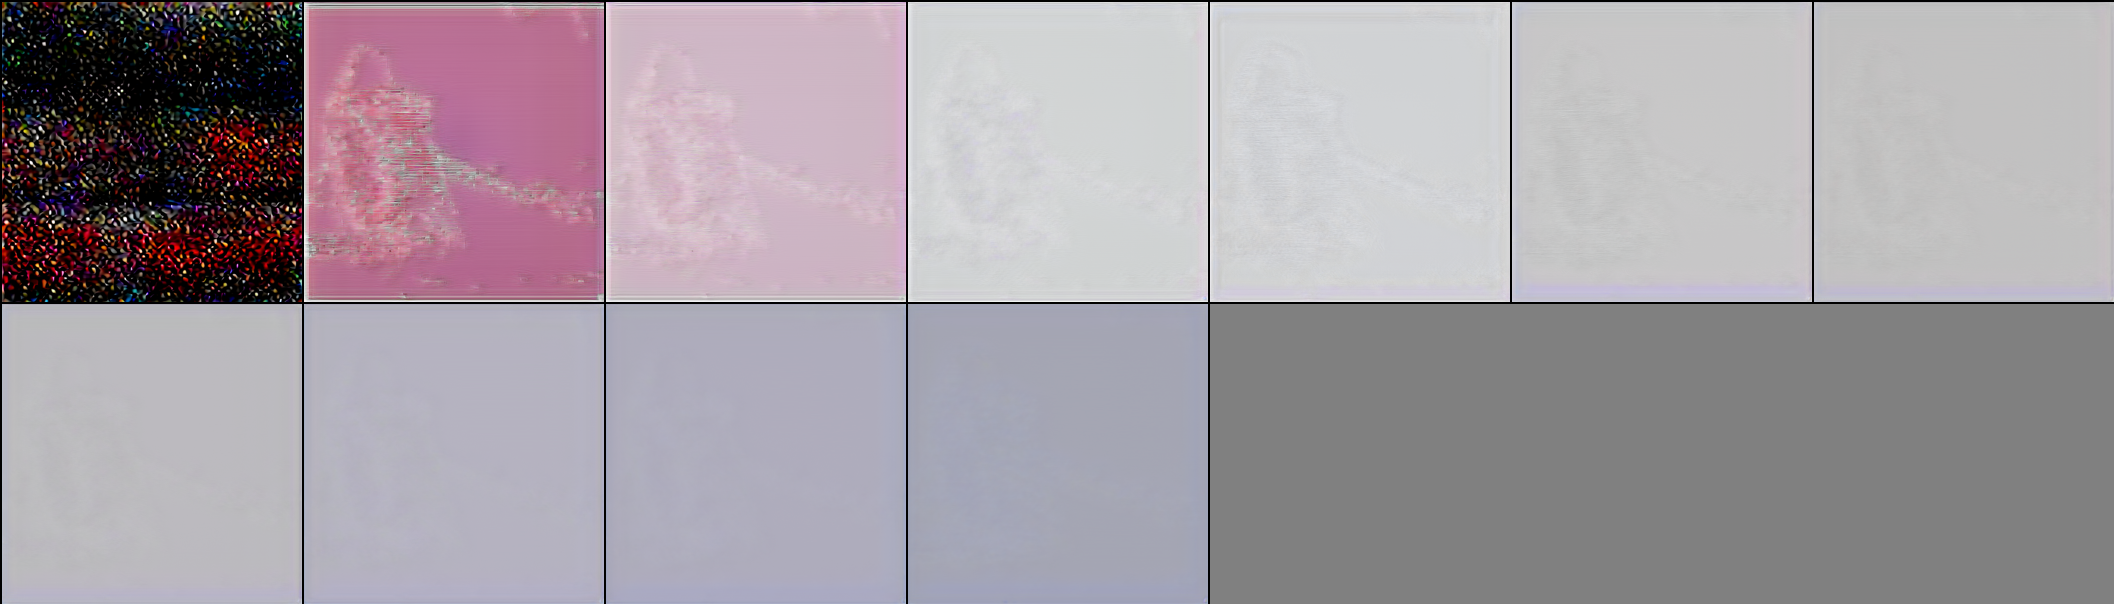

In [56]:
grid, ims_cnxs = plot_latents_to_pil_grid(lats)
grid

**1.** In the 2nd (=10th) image I can see the contour of the shoe as in the guidance image. But over time, the image get's destroyed.<br/>
**2.** The 1st (=5th) image looks extremely weird.

**Hypothesis re 1:** The image vanishes when using cnxs, because it gets pushed outside the (0,1) boundary. This might becaise I need to rescale the noise prediceted by cnxs (which I currently don't do).

In [73]:
def percentage_outside_range(x, lo=0,hi=255):
    x = np.array(x).flatten()
    return 100*(np.sum(x<lo)+np.sum(x>hi))/len(x)
assert percentage_outside_range([300])==100
assert percentage_outside_range([100])==0
assert percentage_outside_range([[0,0],[-50,200]])==25

In [74]:
print('>>> SDXL')
for i,im in enumerate(ims_sdxl):
    p = percentage_outside_range(im)
    print(f'Step {real_idx(i)}] {p}% of values outside range')

print('>>> CNXS')
for i,im in enumerate(ims_cnxs):
    p = percentage_outside_range(im)
    print(f'Step {real_idx(i)}] {p}% of value outside range')

>>> SDXL
Step 0] 0.0% of values outside range
Step 5] 0.0% of values outside range
Step 10] 0.0% of values outside range
Step 15] 0.0% of values outside range
Step 20] 0.0% of values outside range
Step 25] 0.0% of values outside range
Step 30] 0.0% of values outside range
Step 35] 0.0% of values outside range
Step 40] 0.0% of values outside range
Step 45] 0.0% of values outside range
Step 49] 0.0% of values outside range
>>> CNXS
Step 0] 0.0% of value outside range
Step 5] 0.0% of value outside range
Step 10] 0.0% of value outside range
Step 15] 0.0% of value outside range
Step 20] 0.0% of value outside range
Step 25] 0.0% of value outside range
Step 30] 0.0% of value outside range
Step 35] 0.0% of value outside range
Step 40] 0.0% of value outside range
Step 45] 0.0% of value outside range
Step 49] 0.0% of value outside range


Doesn't seem to be.

**Q:** Does PIL clip the pixel values?

In [103]:
# from diffusers
def numpy_to_pil(im): return Image.fromarray((im * 255).round().astype("uint8"))
def pil_to_numpy(im): return np.array(im).astype(np.float32) / 255.0

In [110]:
bound = (0,1)
rand_x = np.random.uniform(*bound,(300,300,3))
np.allclose(pil_to_numpy(numpy_to_pil(rand_x)), rand_x, rtol=1e-02, atol=1e-02)

True

In [111]:
bound = (-1,2)
rand_x = np.random.uniform(*bound,(300,300,3))
np.allclose(pil_to_numpy(numpy_to_pil(rand_x)), rand_x, rtol=1e-02, atol=1e-02)

False

**A:** Yes, it does.

=> I need to redo the "value outside range" analysis

In [127]:
ims_cnxs_pt = lats2imgs(lats,output_type='pt')

  0%|          | 0/50 [00:00<?, ?it/s]

In [133]:
print('>>> CNXS')
for i,im in enumerate(ims_cnxs_pt):
    p = percentage_outside_range(im, lo=0, hi=1)
    print(f'Step {i}] {p}% of value outside range')

>>> CNXS
Step 0] 0.0% of value outside range
Step 1] 0.0% of value outside range
Step 2] 0.0% of value outside range
Step 3] 0.0% of value outside range
Step 4] 0.0% of value outside range
Step 5] 0.0% of value outside range
Step 6] 0.0% of value outside range
Step 7] 0.0% of value outside range
Step 8] 0.0% of value outside range
Step 9] 0.0% of value outside range
Step 10] 0.0% of value outside range
Step 11] 0.0% of value outside range
Step 12] 0.0% of value outside range
Step 13] 0.0% of value outside range
Step 14] 0.0% of value outside range
Step 15] 0.0% of value outside range
Step 16] 0.0% of value outside range
Step 17] 0.0% of value outside range
Step 18] 0.0% of value outside range
Step 19] 0.0% of value outside range
Step 20] 0.0% of value outside range
Step 21] 0.0% of value outside range
Step 22] 0.0% of value outside range
Step 23] 0.0% of value outside range
Step 24] 0.0% of value outside range
Step 25] 0.0% of value outside range
Step 26] 0.0% of value outside range
St

Hmm, but at least image 0 had values < 0! I saw that yesterday. Where are they?

In [ ]:
assert False

In [134]:
def color_channel_hist(ims,idxs=None):
    if idxs is None: idxs = list(range(len(ims)))
    for idx in idxs:
        im = ims[idx]
        channels = [np.array(im)[:,:,c].flatten() for c in range(3)]
        
        fig, axes = plt.subplots(1, 3, figsize=(7, 1.5))

        orig_idx = min(49,idx*5)
        titles = [f'Red {orig_idx}', f'Green {orig_idx}', f'Blue {orig_idx}']
        cols = ['red','green','blue']
        for i, ax in enumerate(axes):
            ax.hist(channels[i], bins=50, color=cols[i], alpha=0.7)
            ax.set_title(titles[i])
            ax.set_xlim(-100, 350)
            ax.set_yticklabels([])
            if idx>0: ax.set_xticklabels([])
            #ax.set_xlabel('Intensity')
            #ax.set_ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()

def color_channel_hist(ims,idxs=None, cols=5):    
    if idxs is None: idxs = list(range(len(ims)))

    rows = len(idxs) // cols
    if rows * cols < len(idxs): rows += 1
    
    fig, axes = plt.subplots(rows, cols, figsize=(rows*4, cols*4))

    for i, ax in enumerate(axes.ravel()):
        if i>= len(idxs): break
        im = ims[i]
        channels = [np.array(im)[:,:,c].flatten() for c in range(3)]
        colors = ['red', 'green', 'blue']
        for c in range(3):
            ax.hist(channels[c], bins=50, color=colors[c], alpha=0.5)
        
        ax.set_xlim(0, 255)
        ax.set_title(f'Image {min(49,i*5)}')
        if i == 0:
            ax.set_ylabel('Frequency')
        else:
            ax.set_yticklabels([])
            ax.set_ylabel('')

    plt.tight_layout()
    plt.show()

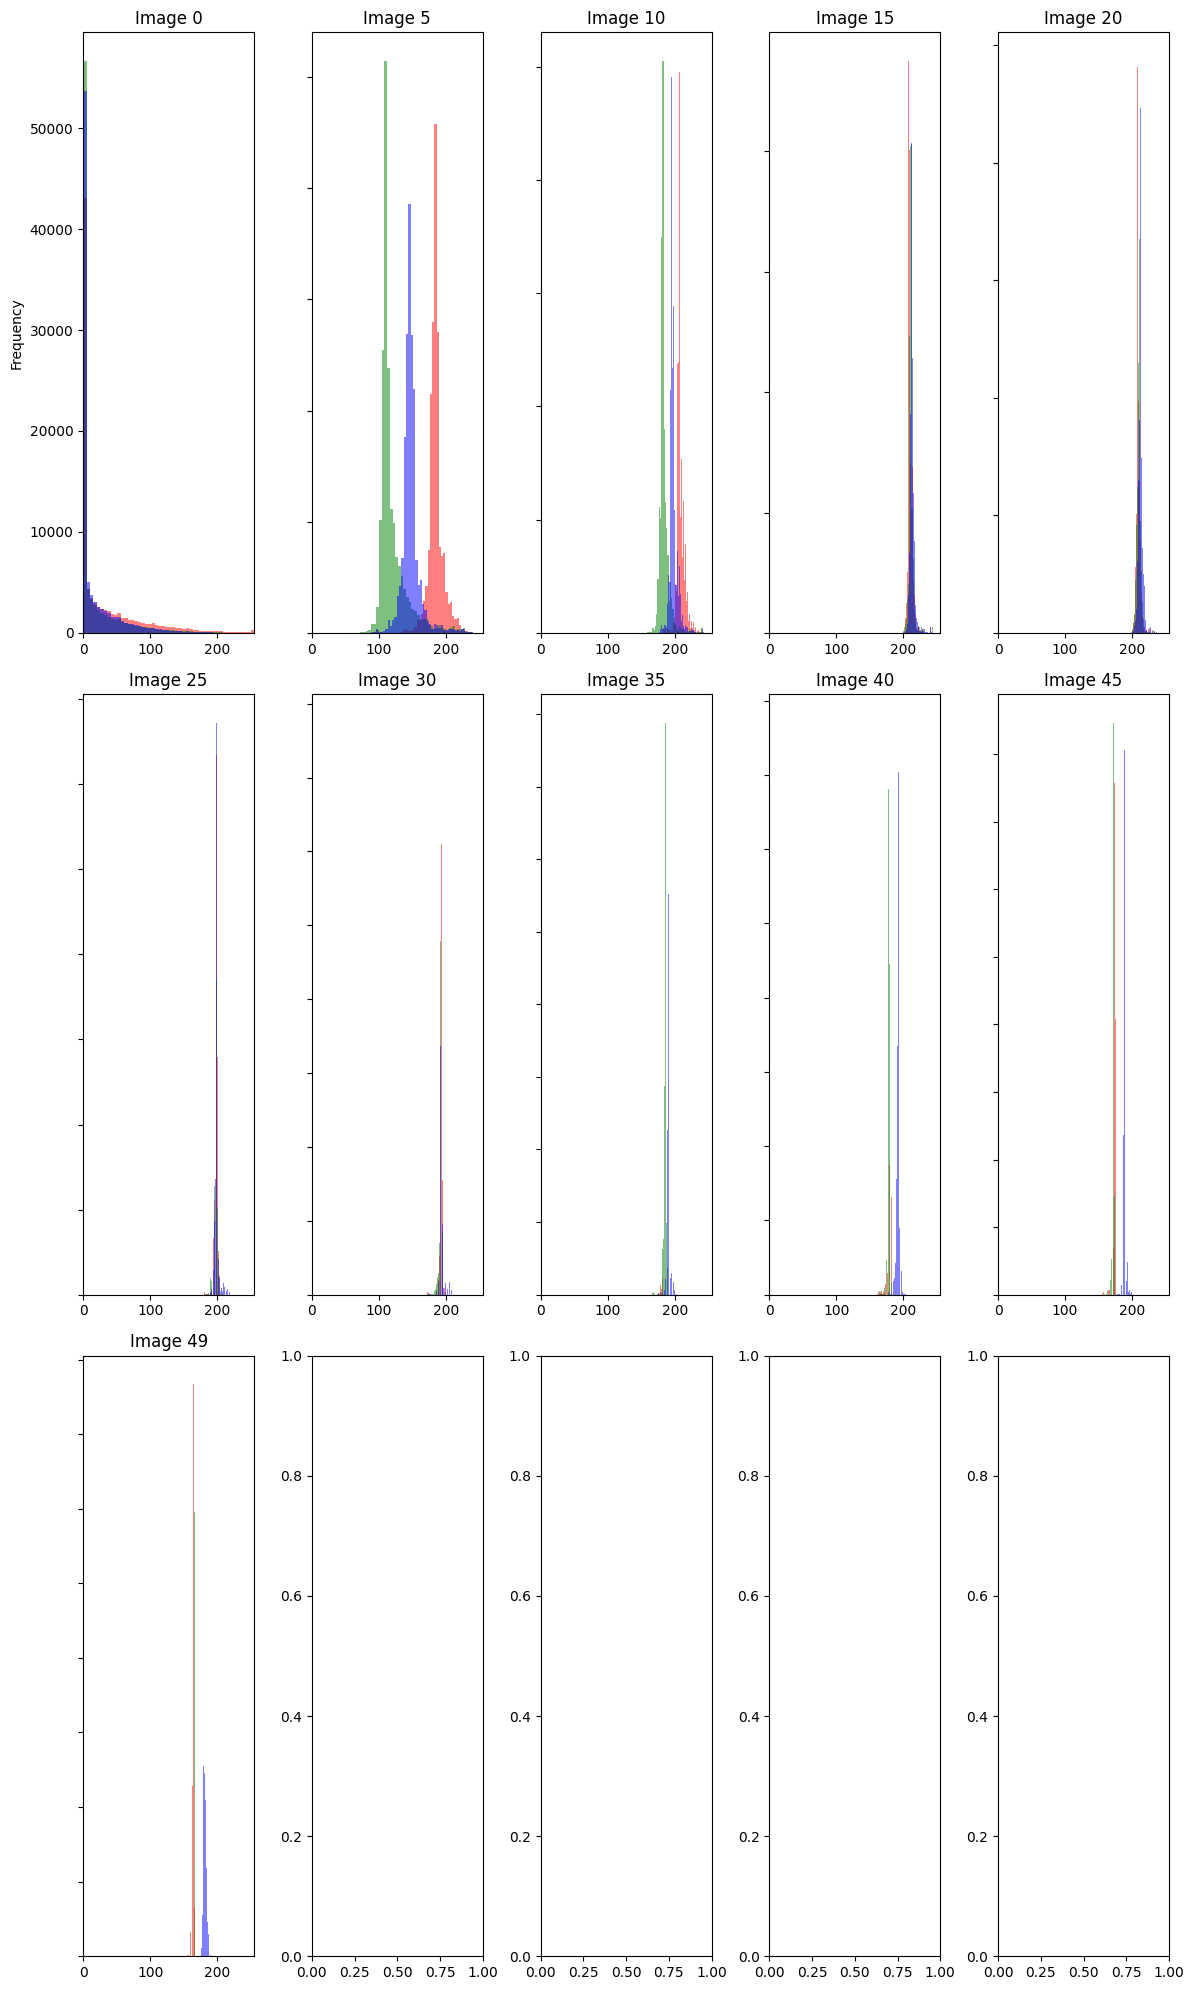

In [135]:
color_channel_hist(ims_cnxs)

The images are not decoded correctly! The RGB values in the initial image (random noise) go from -2 to 2, but should go from 0 to 1

In [136]:
for i,_,im in ims:
    color_channel_hist(im[0],i)

NameError: name 'ims' is not defined